In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.dataset.common import ListDataset



In [48]:
df = pd.read_excel('Problem_C_Data_Wordle.xlsx', skiprows=1, index_col='Date_c')
df

,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
Date_c,,,,,,,,,,,
2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2
2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1
2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2
2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1
2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1
2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2
2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4


In [49]:
df_new = df.iloc[: , [2]].copy() 
df_new1 = df_new.iloc[::-1]
df_new1
df_new

,Number of reported results
Date_c,
2022-12-31,20380
2022-12-30,21204
2022-12-29,20001
2022-12-28,20160
2022-12-27,20879
...,...
2022-01-11,153880
2022-01-10,107134
2022-01-09,91477


<ipython-input-50-b303eae70e15>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(df_new1).show()


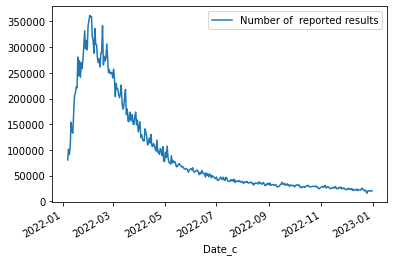

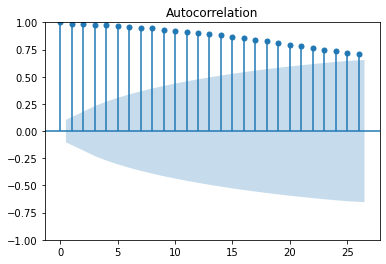

In [50]:
df_new1.plot() 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_new1).show() 

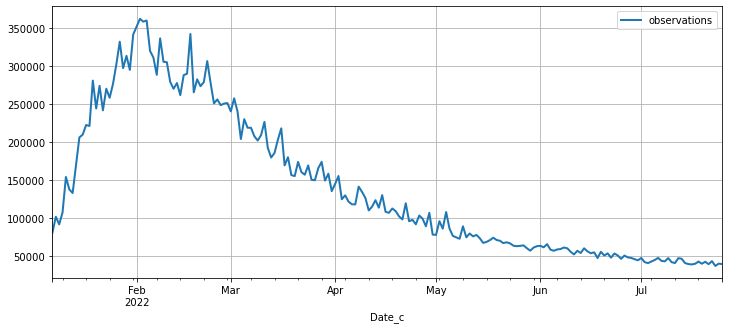

In [51]:
df_new1[:200].plot(figsize=(12, 5), linewidth=2)
plt.grid()
plt.legend(["observations"])
plt.show()

In [52]:
training_data = ListDataset(
    [{"start": df_new1.index[0], "target": df_new1['Number of  reported results'][:]}],
    freq = "D"
)

In [53]:
estimator = DeepAREstimator(freq="D", 
                            prediction_length=30,
                            context_length=90,
                            trainer=Trainer(ctx="cpu", epochs=10, learning_rate=1e-3))

In [54]:
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:05<00:00,  9.50it/s, epoch=10/10, avg_epoch_loss=9.97]


In [60]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=training_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

# get the predicted value for March 1st
prediction = forecasts[-1].mean[-1]

# get the lower and upper bounds of the 95% prediction interval
lower_bound = forecasts[-1].quantile(0.025)[-1]
upper_bound = forecasts[-1].quantile(0.975)[-1]

print('The predicted number of users on March 1st is', round(prediction))
print('The 95% prediction interval is', round(lower_bound), 'to', round(upper_bound))

The predicted number of users on March 1st is 21721
The 95% prediction interval is 18863 to 24323


In [61]:
test_data = ListDataset(
    [
        {"start": df_new1.index[0], "target": df_new1['Number of  reported results'][:-20]},
        {"start": df_new1.index[0], "target": df_new1['Number of  reported results'][:-10]},
        {"start": df_new1.index[0], "target": df_new1['Number of  reported results'][:]}
    ],
    freq = "D"
)

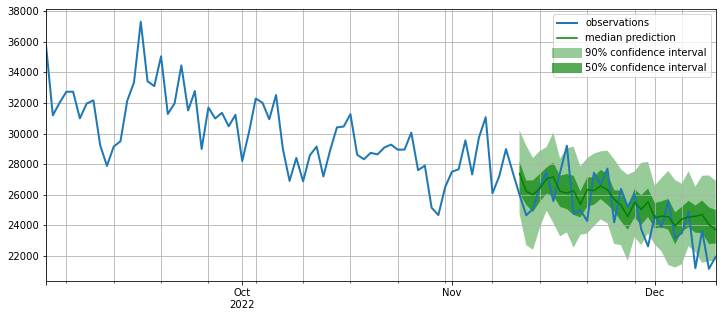

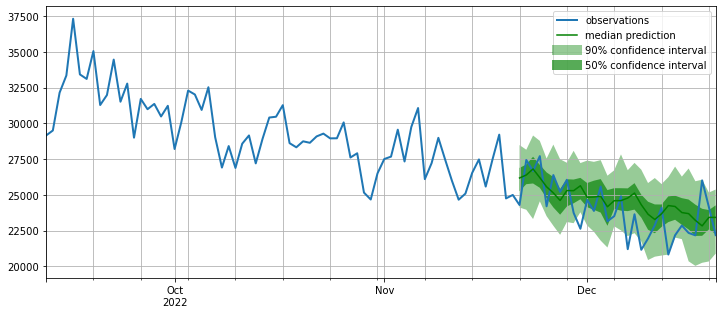

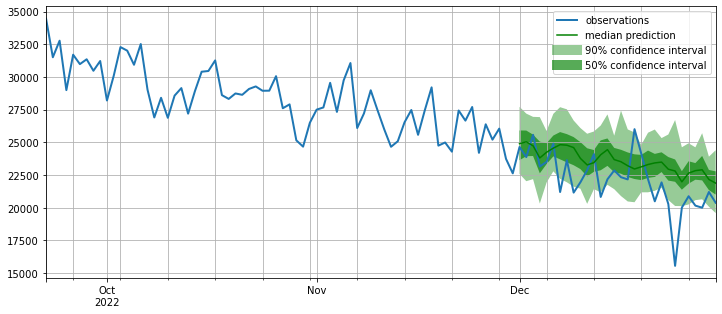

In [62]:
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=100, num_plots=3)

In [ ]:
estimator = DeepAREstimator(freq="1day", 
                            prediction_length=60, 
                            trainer=Trainer(epochs=10))

# load the historical data
df = pd.read_csv('your_data_file.csv', index_col='Date', parse_dates=True)

# create a ListDataset from the DataFrame
training_data = ListDataset(
    [{"start": df.index[0], "target": df['Number of users'][:-30]}],
    freq = "D"
)

# specify the hyperparameters of the model
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10, 10],
    prediction_length=30,
    context_length=90,
    freq="D",
    trainer=Trainer(ctx="cpu", epochs=10, learning_rate=1e-3)
)

# train the model on the training data
predictor = estimator.train(training_data=training_data)

# make predictions on the last 30 days of the training data
forecast_it, ts_it = make_evaluation_predictions(
    dataset=training_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

# get the predicted value for March 1st
prediction = forecasts[-1].mean[-1]

# get the lower and upper bounds of the 95% prediction interval
lower_bound = forecasts[-1].quantile(0.025)[-1]
upper_bound = forecasts[-1].quantile(0.975)[-1]

print('The predicted number of users on March 1st is', round(prediction))
print('The 95% prediction interval is', round(lower_bound), 'to', round(upper_bound))
